# This Notebook will include graphical analysis of Amazon review data

Source:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects.

Jianmo Ni, Jiacheng Li, Julian McAuley.

Empirical Methods in Natural Language Processing (EMNLP), 2019.

https://nijianmo.github.io/amazon/index.html

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

------------------------------

Sentiment analysis code shall be later on transfered to .py files for easy execution

---------------

# Data Transformation

## Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import json
import os

# custom files
from neural_network import prepare_data, build_model, train_model, evaluate_model, plot_training_progress, model_predict, prepare_nn_input
from word_vectorization import create_tf_vector_all_reviews, create_idf_dictionary, create_word_vector_dict, create_input_word_vector
from data_transformation import get_overview, clean_data, balancing
from knn import knn

Using TensorFlow backend.


--------

## Import Data

In [8]:
# get all files to load

path = "./data"
files = os.listdir(path)
files = [element for element in files if not "FULL" in element]

In [9]:
# load first dataset
data = pd.read_json(path+"/"+files[0], lines = True)

# load other datasets
for i in range(1, len(files)):
    
    tmp_data = pd.read_json(path+"/"+files[i], lines = True)
    data = data.append(tmp_data)

In [10]:
# read subset data
#path = "./data/AMAZON_FASHION_5.json"

# read full data
#path = "./data/AMAZON_FASHION_FULL.json"

#data = pd.read_json(path, lines = True)

-------

# Data overview

In [11]:
get_overview(data)

Data has 28874 datapoints.
Data has 12 columns.
Columns: dtype
{'overall': 'int64', 'verified': 'bool', 'reviewTime': 'object', 'reviewerID': 'object', 'asin': 'object', 'style': 'object', 'reviewerName': 'object', 'reviewText': 'object', 'summary': 'object', 'unixReviewTime': 'int64', 'vote': 'object', 'image': 'object'}


--------

## Data Cleaning

In [12]:
keepColumns = ["overall", "reviewText"]
data = clean_data(data, keepColumns)

Dropped 10 columns.
Droppend 29 null values.
Data contains now 28845 datapoints.


-------

## Balancing

Most saved rating is 5 with 18655 datapoints.
Least saved rating is 2 with 1018 datapoints.


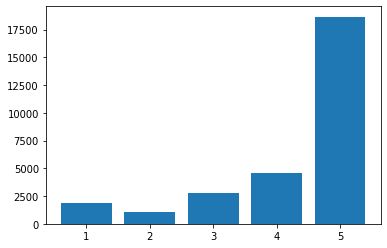

Dataset now contains 5090 datapoints.


In [13]:
max_num = None # replace lateron
data = balancing(data, balancing = True, max_num = max_num)

Most saved rating is 1 with 1018 datapoints.
Least saved rating is 1 with 1018 datapoints.


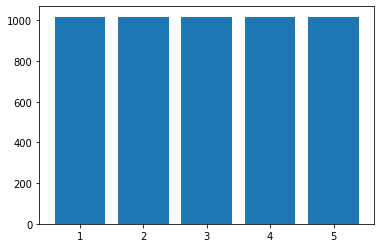

In [14]:
# check balancing
balancing(data, balancing = False, max_num = None)

-------

## Word Vectors

In [15]:
def save_dict_to_json(dic, filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "w")
    json.dump(dic, f)
    f.close()

def load_dict_from_json(filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "r")
    dic = json.loads(f.read())
    f.close()
    
    return dic

In [16]:
# create review_dict
review_dict = create_tf_vector_all_reviews(data)
#save_dict_to_json(review_dict, "review_dict")

# create idf dict
idf_dict = create_idf_dictionary(review_dict)
save_dict_to_json(idf_dict, "idf_dict")

# create word_vec_dict
word_vec_dict = create_word_vector_dict(review_dict, idf_dict) # speed = 0.2 seconds per datapoint
#np.save('word_vec_dict.npy', word_vec_dict)

# include word_vec_dict in dataframe
data["word_vectors"] = list(word_vec_dict.values())

In [17]:
# alternative without processing word vectors
#word_vec_dict = np.load('word_vec_dict.npy', allow_pickle=True)[()]
#data["word_vectors"] = word_vec_dict.values()
#data.to_json("data_with_word_vectors.json")
#data = pd.read_json("data_with_word_vectors.json")

In [18]:
# get a look at the data
data.head()

,overall,reviewText,word_vectors
0,2,Ok looking card (not great). But I would have ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,I ordered a bunch of gift cards and when the p...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,I ordered a bunch of gift cards and when the p...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,Don't like the tin - it looks tacky!,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,I ordered a bunch of gift cards and when the p...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


------

## Train Test Split

In [19]:
# create test and training dataset
test_size = 0.2
train_data, test_data = train_test_split(data,
                                         test_size = test_size,
                                         shuffle=True,
                                         stratify = data["overall"]
                                        )

train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

In [20]:
# drop data dataframe
data = 0

-------

# Now start Sentiment analysis

-------

## knn

In [18]:
# test single n

# init variables
data_point = test_data[:1]
data_point_class = int(data_point["overall"])
data_point = np.asarray(data_point["word_vectors"].to_list())
n = 3

# calc class
calc_class = knn(train_data, data_point, n)

print(f"Test Datapoint has class: {calc_class}")
print(f"Original class was {data_point_class}")

Test Datapoint has class: 3
Original class was 3


In [19]:
# test multiple n

# init variables
data_point = test_data[:1]
data_point_class = int(data_point["overall"])
data_point = np.asarray(data_point["word_vectors"].to_list())
n = [1,2,3,4,5]

# calc class
calc_class = knn(train_data, data_point, n)

print(f"Test Datapoint has class: {calc_class}")
print(f"Original class was {data_point_class}")

Test Datapoint has class: {1: 3, 2: 3, 3: 3, 4: 3, 5: 3}
Original class was 3


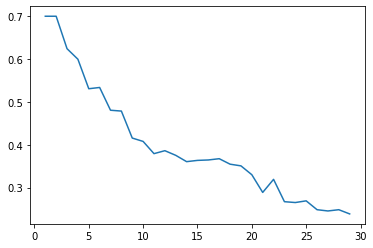

In [20]:
# test accuracy of combined dataset

# get test data
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

# init variables
pred_class = []
n_test = list(range(1,30))

# get classes
count = 0
for t_vector in test_vectors:

    pred_class.append(knn(train_data, np.asarray(t_vector), n_test))
    
    count += 1
    if (count % 100) == 0:
        
        print(f"Step {count}")
    
# init accuracy dict
acc_dict = {}

for sub_n in n_test:
    
    sub_n_val_classes = []
    
    for test_el in pred_class:
        
        sub_n_val_classes.append(test_el[sub_n])
    
    # get accuracy of sub_n
    accuracy = accuracy_score(test_classes, sub_n_val_classes)
    acc_dict[sub_n] = accuracy

# visualize
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.show()

Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Step 1100
Step 1200
Step 1300
Step 1400
Step 1500
Step 1600
Step 1700
Step 1800
Step 1900
Step 2000


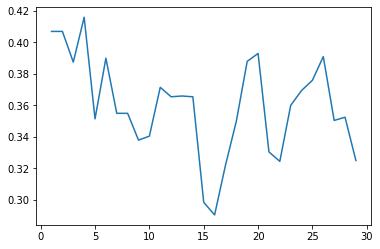

In [17]:
# test accuracy of full Amazon fashion

# get test data
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

# init variables
pred_class = []
n_test = list(range(1,30))

# get classes
count = 0
for t_vector in test_vectors:

    pred_class.append(knn(train_data, np.asarray(t_vector), n_test))
    
    count += 1
    if (count % 100) == 0:
        
        print(f"Step {count}")
    
# init accuracy dict
acc_dict = {}

for sub_n in n_test:
    
    sub_n_val_classes = []
    
    for test_el in pred_class:
        
        sub_n_val_classes.append(test_el[sub_n])
    
    # get accuracy of sub_n
    accuracy = accuracy_score(test_classes, sub_n_val_classes)
    acc_dict[sub_n] = accuracy

# visualize
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.show()

----------

# Neural Network

## train model

Started training.
Finished training.
1018/1018 [==============================] - 0s 17us/step
Model has a loss of 0.6665894604619219 and an accuracy of 0.7730844616889954


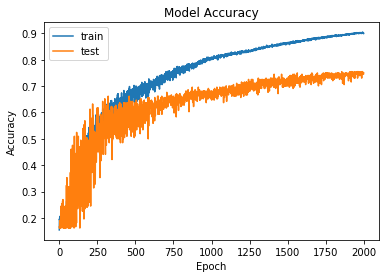

In [52]:
# get train, test and val data
x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 1, neuron_count = [20], activation_functions = ["sigmoid"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 2000, batch_size = 64, show_output = False)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

# save model
model.save("amazonreviews")

--------

## NN Predict on user Data

In [25]:
# load model and idf_dict
model = keras.models.load_model("amazonreviews")
idf_dict = load_dict_from_json("idf_dict")

In [51]:
# get user input
input_string = input("Please enter your Product review: ")

# process string to word vector
word_vec = create_input_word_vector(input_string, idf_dict) # also usable for knn
input_vector = prepare_nn_input(word_vec, shape)

# predict review score
review_score = model_predict(input_vector, model)

# print user output
print(f"Your score is most likly: {review_score}")

Please enter your Product review: Terrible. Hate it
Your score is most likly: 1


In [22]:
# get user input
input_string = input("Please enter your Product review: ")

# process string to word vector
word_vec = create_input_word_vector(input_string, idf_dict) # also usable for knn
input_vector = prepare_nn_input(word_vec, shape)

# predict review score
review_score = model_predict(input_vector, model)

# print user output
print(f"Your score is most likly: {review_score}")

Please enter your Product review: Great Product. love it buy again
Your score is most likly: 5


In [50]:
# get user input
input_string = input("Please enter your Product review: ")

# process string to word vector
word_vec = create_input_word_vector(input_string, idf_dict) # also usable for knn
input_vector = prepare_nn_input(word_vec, shape)

# predict review score
review_score = model_predict(input_vector, model)

# print user output
print(f"Your score is most likly: {review_score}")

Please enter your Product review: quite average. there are okay points but also negative points. ist very good to get an insight but he bad points are still present
Your score is most likly: 3


In [29]:
# get user input
input_string = """I like to post a lot of stories on Instagram and this camera does help me with that.
Clarity is also very good and very handy as well. I use it with my tripod stand which makes it even
easier for making better videos. I will say battery backup could have been.
better and the overall quality could have been a little improved as well.
But for the price, I think it totally suffices. 
"""

# process string to word vector
word_vec = create_input_word_vector(input_string, idf_dict) # also usable for knn
input_vector = prepare_nn_input(word_vec, shape)

# predict review score
review_score = model_predict(input_vector, model)

# print user output
print(f"Your score is most likly: {review_score}")

Your score is most likly: 4


--------

## Test different model configurations

### newer tests

Started training.
Finished training.
1018/1018 [==============================] - 0s 17us/step
Model has a loss of 0.8895951445069903 and an accuracy of 0.7671905755996704


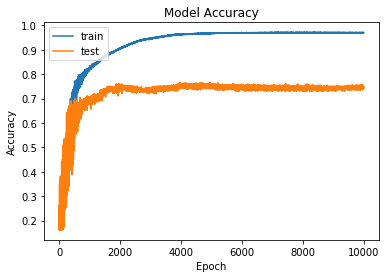

In [24]:
# get train, test and val data
x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 1, neuron_count = [20], activation_functions = ["sigmoid"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 10000, batch_size = 64, show_output = False)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

Started training.
Train on 3868 samples, validate on 204 samples
Epoch 1/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.6389 - sparse_categorical_accuracy: 0.1877 - val_loss: 1.6131 - val_sparse_categorical_accuracy: 0.1667
Epoch 2/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.6152 - sparse_categorical_accuracy: 0.2115 - val_loss: 1.6210 - val_sparse_categorical_accuracy: 0.1667
Epoch 3/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.6152 - sparse_categorical_accuracy: 0.2117 - val_loss: 1.6161 - val_sparse_categorical_accuracy: 0.1618
Epoch 4/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 1.6155 - sparse_categorical_accuracy: 0.2009 - val_loss: 1.6275 - val_sparse_categorical_accuracy: 0.1912
Epoch 5/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 1.6138 - sparse_categorical_accuracy: 0.2050 - val_loss: 1.6582 - val_sparse_categorical_accuracy: 0.1618
Epoch 6/2000
38

Epoch 45/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.5583 - sparse_categorical_accuracy: 0.3330 - val_loss: 1.5677 - val_sparse_categorical_accuracy: 0.2304
Epoch 46/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.5546 - sparse_categorical_accuracy: 0.3061 - val_loss: 1.5590 - val_sparse_categorical_accuracy: 0.3137
Epoch 47/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.5513 - sparse_categorical_accuracy: 0.3260 - val_loss: 1.5694 - val_sparse_categorical_accuracy: 0.2598
Epoch 48/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.5495 - sparse_categorical_accuracy: 0.3397 - val_loss: 1.5593 - val_sparse_categorical_accuracy: 0.3775
Epoch 49/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.5454 - sparse_categorical_accuracy: 0.3446 - val_loss: 1.5646 - val_sparse_categorical_accuracy: 0.2157
Epoch 50/2000
3868/3868 [==============================] - 7s 2ms/step - lo

3868/3868 [==============================] - 7s 2ms/step - loss: 1.3651 - sparse_categorical_accuracy: 0.4413 - val_loss: 1.4140 - val_sparse_categorical_accuracy: 0.3088
Epoch 90/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.3622 - sparse_categorical_accuracy: 0.4403 - val_loss: 1.3869 - val_sparse_categorical_accuracy: 0.4216
Epoch 91/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.3596 - sparse_categorical_accuracy: 0.4369 - val_loss: 1.3941 - val_sparse_categorical_accuracy: 0.3284
Epoch 92/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.3561 - sparse_categorical_accuracy: 0.4387 - val_loss: 1.3874 - val_sparse_categorical_accuracy: 0.4265
Epoch 93/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.3544 - sparse_categorical_accuracy: 0.4416 - val_loss: 1.3819 - val_sparse_categorical_accuracy: 0.4510
Epoch 94/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.3501 - s

3868/3868 [==============================] - 7s 2ms/step - loss: 1.2650 - sparse_categorical_accuracy: 0.4762 - val_loss: 1.2983 - val_sparse_categorical_accuracy: 0.4363
Epoch 134/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.2633 - sparse_categorical_accuracy: 0.4654 - val_loss: 1.3093 - val_sparse_categorical_accuracy: 0.4902
Epoch 135/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.2604 - sparse_categorical_accuracy: 0.4705 - val_loss: 1.2966 - val_sparse_categorical_accuracy: 0.4510
Epoch 136/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.2571 - sparse_categorical_accuracy: 0.4829 - val_loss: 1.3024 - val_sparse_categorical_accuracy: 0.4559
Epoch 137/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.2564 - sparse_categorical_accuracy: 0.4775 - val_loss: 1.2923 - val_sparse_categorical_accuracy: 0.4265
Epoch 138/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.253

3868/3868 [==============================] - 7s 2ms/step - loss: 1.1776 - sparse_categorical_accuracy: 0.5119 - val_loss: 1.2155 - val_sparse_categorical_accuracy: 0.4853
Epoch 178/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.1772 - sparse_categorical_accuracy: 0.5080 - val_loss: 1.2135 - val_sparse_categorical_accuracy: 0.4608
Epoch 179/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.1745 - sparse_categorical_accuracy: 0.5163 - val_loss: 1.2111 - val_sparse_categorical_accuracy: 0.4461
Epoch 180/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.1732 - sparse_categorical_accuracy: 0.5173 - val_loss: 1.2116 - val_sparse_categorical_accuracy: 0.4412
Epoch 181/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.1721 - sparse_categorical_accuracy: 0.5096 - val_loss: 1.2162 - val_sparse_categorical_accuracy: 0.4755
Epoch 182/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.169

3868/3868 [==============================] - 7s 2ms/step - loss: 1.1173 - sparse_categorical_accuracy: 0.5517 - val_loss: 1.1571 - val_sparse_categorical_accuracy: 0.5392
Epoch 222/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.1161 - sparse_categorical_accuracy: 0.5468 - val_loss: 1.1570 - val_sparse_categorical_accuracy: 0.5196
Epoch 223/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.1159 - sparse_categorical_accuracy: 0.5571 - val_loss: 1.1555 - val_sparse_categorical_accuracy: 0.4755
Epoch 224/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.1144 - sparse_categorical_accuracy: 0.5504 - val_loss: 1.1548 - val_sparse_categorical_accuracy: 0.5098
Epoch 225/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.1124 - sparse_categorical_accuracy: 0.5483 - val_loss: 1.1508 - val_sparse_categorical_accuracy: 0.4755
Epoch 226/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.112

3868/3868 [==============================] - 7s 2ms/step - loss: 1.0730 - sparse_categorical_accuracy: 0.5750 - val_loss: 1.1189 - val_sparse_categorical_accuracy: 0.5539
Epoch 266/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0737 - sparse_categorical_accuracy: 0.5835 - val_loss: 1.1258 - val_sparse_categorical_accuracy: 0.5588
Epoch 267/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0702 - sparse_categorical_accuracy: 0.5794 - val_loss: 1.1190 - val_sparse_categorical_accuracy: 0.5441
Epoch 268/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0713 - sparse_categorical_accuracy: 0.5851 - val_loss: 1.1224 - val_sparse_categorical_accuracy: 0.5490
Epoch 269/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0707 - sparse_categorical_accuracy: 0.5801 - val_loss: 1.1171 - val_sparse_categorical_accuracy: 0.5441
Epoch 270/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.069

3868/3868 [==============================] - 7s 2ms/step - loss: 1.0373 - sparse_categorical_accuracy: 0.6086 - val_loss: 1.0928 - val_sparse_categorical_accuracy: 0.5735
Epoch 310/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0357 - sparse_categorical_accuracy: 0.6044 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.5245
Epoch 311/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0360 - sparse_categorical_accuracy: 0.6099 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.5490
Epoch 312/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0345 - sparse_categorical_accuracy: 0.6029 - val_loss: 1.0978 - val_sparse_categorical_accuracy: 0.5588
Epoch 313/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0338 - sparse_categorical_accuracy: 0.6088 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.5833
Epoch 314/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.033

3868/3868 [==============================] - 7s 2ms/step - loss: 1.0050 - sparse_categorical_accuracy: 0.6264 - val_loss: 1.0763 - val_sparse_categorical_accuracy: 0.5931
Epoch 354/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0054 - sparse_categorical_accuracy: 0.6267 - val_loss: 1.0778 - val_sparse_categorical_accuracy: 0.5784
Epoch 355/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0039 - sparse_categorical_accuracy: 0.6293 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.5686
Epoch 356/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0029 - sparse_categorical_accuracy: 0.6238 - val_loss: 1.0727 - val_sparse_categorical_accuracy: 0.5735
Epoch 357/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.0030 - sparse_categorical_accuracy: 0.6316 - val_loss: 1.0763 - val_sparse_categorical_accuracy: 0.5882
Epoch 358/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 1.002

3868/3868 [==============================] - 7s 2ms/step - loss: 0.9772 - sparse_categorical_accuracy: 0.6507 - val_loss: 1.0705 - val_sparse_categorical_accuracy: 0.6275
Epoch 398/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9761 - sparse_categorical_accuracy: 0.6505 - val_loss: 1.0577 - val_sparse_categorical_accuracy: 0.6127
Epoch 399/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9752 - sparse_categorical_accuracy: 0.6448 - val_loss: 1.0577 - val_sparse_categorical_accuracy: 0.6176
Epoch 400/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9736 - sparse_categorical_accuracy: 0.6458 - val_loss: 1.0661 - val_sparse_categorical_accuracy: 0.6373
Epoch 401/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9717 - sparse_categorical_accuracy: 0.6479 - val_loss: 1.0662 - val_sparse_categorical_accuracy: 0.5784
Epoch 402/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.973

3868/3868 [==============================] - 7s 2ms/step - loss: 0.9495 - sparse_categorical_accuracy: 0.6608 - val_loss: 1.0443 - val_sparse_categorical_accuracy: 0.6324
Epoch 442/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9469 - sparse_categorical_accuracy: 0.6649 - val_loss: 1.0484 - val_sparse_categorical_accuracy: 0.6373
Epoch 443/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9471 - sparse_categorical_accuracy: 0.6652 - val_loss: 1.0516 - val_sparse_categorical_accuracy: 0.6471
Epoch 444/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9447 - sparse_categorical_accuracy: 0.6691 - val_loss: 1.0533 - val_sparse_categorical_accuracy: 0.6225
Epoch 445/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9447 - sparse_categorical_accuracy: 0.6662 - val_loss: 1.0394 - val_sparse_categorical_accuracy: 0.6078
Epoch 446/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.945

3868/3868 [==============================] - 7s 2ms/step - loss: 0.9158 - sparse_categorical_accuracy: 0.6854 - val_loss: 1.0373 - val_sparse_categorical_accuracy: 0.6225
Epoch 486/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9155 - sparse_categorical_accuracy: 0.6849 - val_loss: 1.0315 - val_sparse_categorical_accuracy: 0.6471
Epoch 487/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9155 - sparse_categorical_accuracy: 0.6849 - val_loss: 1.0384 - val_sparse_categorical_accuracy: 0.6078
Epoch 488/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9143 - sparse_categorical_accuracy: 0.6895 - val_loss: 1.0344 - val_sparse_categorical_accuracy: 0.6275
Epoch 489/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.9147 - sparse_categorical_accuracy: 0.6838 - val_loss: 1.0285 - val_sparse_categorical_accuracy: 0.6422
Epoch 490/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.913

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8887 - sparse_categorical_accuracy: 0.6988 - val_loss: 1.0291 - val_sparse_categorical_accuracy: 0.6373
Epoch 530/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8882 - sparse_categorical_accuracy: 0.6967 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.6324
Epoch 531/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8867 - sparse_categorical_accuracy: 0.6970 - val_loss: 1.0440 - val_sparse_categorical_accuracy: 0.6127
Epoch 532/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8869 - sparse_categorical_accuracy: 0.7009 - val_loss: 1.0192 - val_sparse_categorical_accuracy: 0.6373
Epoch 533/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8847 - sparse_categorical_accuracy: 0.7027 - val_loss: 1.0180 - val_sparse_categorical_accuracy: 0.6520
Epoch 534/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.884

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8694 - sparse_categorical_accuracy: 0.7024 - val_loss: 1.0167 - val_sparse_categorical_accuracy: 0.6373
Epoch 574/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8689 - sparse_categorical_accuracy: 0.7042 - val_loss: 1.0192 - val_sparse_categorical_accuracy: 0.6275
Epoch 575/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8669 - sparse_categorical_accuracy: 0.7076 - val_loss: 1.0358 - val_sparse_categorical_accuracy: 0.6471
Epoch 576/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8677 - sparse_categorical_accuracy: 0.7053 - val_loss: 1.0166 - val_sparse_categorical_accuracy: 0.6176
Epoch 577/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8683 - sparse_categorical_accuracy: 0.7068 - val_loss: 1.0190 - val_sparse_categorical_accuracy: 0.6520
Epoch 578/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.869

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8525 - sparse_categorical_accuracy: 0.7148 - val_loss: 1.0208 - val_sparse_categorical_accuracy: 0.6176
Epoch 618/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8530 - sparse_categorical_accuracy: 0.7161 - val_loss: 1.0161 - val_sparse_categorical_accuracy: 0.6667
Epoch 619/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8519 - sparse_categorical_accuracy: 0.7159 - val_loss: 1.0235 - val_sparse_categorical_accuracy: 0.6471
Epoch 620/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8529 - sparse_categorical_accuracy: 0.7143 - val_loss: 1.0194 - val_sparse_categorical_accuracy: 0.6471
Epoch 621/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8516 - sparse_categorical_accuracy: 0.7138 - val_loss: 1.0193 - val_sparse_categorical_accuracy: 0.6373
Epoch 622/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.852

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8428 - sparse_categorical_accuracy: 0.7174 - val_loss: 1.0224 - val_sparse_categorical_accuracy: 0.6422
Epoch 662/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8439 - sparse_categorical_accuracy: 0.7174 - val_loss: 1.0341 - val_sparse_categorical_accuracy: 0.6078
Epoch 663/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8444 - sparse_categorical_accuracy: 0.7213 - val_loss: 1.0253 - val_sparse_categorical_accuracy: 0.6520
Epoch 664/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8444 - sparse_categorical_accuracy: 0.7216 - val_loss: 1.0329 - val_sparse_categorical_accuracy: 0.6520
Epoch 665/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8422 - sparse_categorical_accuracy: 0.7182 - val_loss: 1.0292 - val_sparse_categorical_accuracy: 0.6471
Epoch 666/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.842

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8317 - sparse_categorical_accuracy: 0.7280 - val_loss: 1.0234 - val_sparse_categorical_accuracy: 0.6569
Epoch 706/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8325 - sparse_categorical_accuracy: 0.7291 - val_loss: 1.0263 - val_sparse_categorical_accuracy: 0.6176
Epoch 707/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8319 - sparse_categorical_accuracy: 0.7252 - val_loss: 1.0240 - val_sparse_categorical_accuracy: 0.6618
Epoch 708/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8313 - sparse_categorical_accuracy: 0.7288 - val_loss: 1.0276 - val_sparse_categorical_accuracy: 0.6618
Epoch 709/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8302 - sparse_categorical_accuracy: 0.7262 - val_loss: 1.0302 - val_sparse_categorical_accuracy: 0.6618
Epoch 710/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.831

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8230 - sparse_categorical_accuracy: 0.7267 - val_loss: 1.0306 - val_sparse_categorical_accuracy: 0.6275
Epoch 750/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8238 - sparse_categorical_accuracy: 0.7293 - val_loss: 1.0310 - val_sparse_categorical_accuracy: 0.6667
Epoch 751/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8238 - sparse_categorical_accuracy: 0.7254 - val_loss: 1.0309 - val_sparse_categorical_accuracy: 0.6569
Epoch 752/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8215 - sparse_categorical_accuracy: 0.7319 - val_loss: 1.0270 - val_sparse_categorical_accuracy: 0.6520
Epoch 753/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8233 - sparse_categorical_accuracy: 0.7335 - val_loss: 1.0368 - val_sparse_categorical_accuracy: 0.6422
Epoch 754/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.821

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8161 - sparse_categorical_accuracy: 0.7319 - val_loss: 1.0507 - val_sparse_categorical_accuracy: 0.6667
Epoch 794/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8159 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0388 - val_sparse_categorical_accuracy: 0.6569
Epoch 795/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8144 - sparse_categorical_accuracy: 0.7363 - val_loss: 1.0669 - val_sparse_categorical_accuracy: 0.6814
Epoch 796/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8169 - sparse_categorical_accuracy: 0.7319 - val_loss: 1.0369 - val_sparse_categorical_accuracy: 0.6422
Epoch 797/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8147 - sparse_categorical_accuracy: 0.7332 - val_loss: 1.0347 - val_sparse_categorical_accuracy: 0.6422
Epoch 798/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.816

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8083 - sparse_categorical_accuracy: 0.7353 - val_loss: 1.0599 - val_sparse_categorical_accuracy: 0.6569
Epoch 838/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.8086 - sparse_categorical_accuracy: 0.7410 - val_loss: 1.0419 - val_sparse_categorical_accuracy: 0.6618
Epoch 839/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8080 - sparse_categorical_accuracy: 0.7391 - val_loss: 1.0466 - val_sparse_categorical_accuracy: 0.6225
Epoch 840/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8086 - sparse_categorical_accuracy: 0.7381 - val_loss: 1.0394 - val_sparse_categorical_accuracy: 0.6667
Epoch 841/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8092 - sparse_categorical_accuracy: 0.7412 - val_loss: 1.0466 - val_sparse_categorical_accuracy: 0.6422
Epoch 842/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.806

3868/3868 [==============================] - 7s 2ms/step - loss: 0.8038 - sparse_categorical_accuracy: 0.7430 - val_loss: 1.0481 - val_sparse_categorical_accuracy: 0.6569
Epoch 882/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8033 - sparse_categorical_accuracy: 0.7412 - val_loss: 1.0448 - val_sparse_categorical_accuracy: 0.6520
Epoch 883/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8030 - sparse_categorical_accuracy: 0.7415 - val_loss: 1.0553 - val_sparse_categorical_accuracy: 0.6814
Epoch 884/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8018 - sparse_categorical_accuracy: 0.7443 - val_loss: 1.0472 - val_sparse_categorical_accuracy: 0.6422
Epoch 885/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.8020 - sparse_categorical_accuracy: 0.7435 - val_loss: 1.0446 - val_sparse_categorical_accuracy: 0.6569
Epoch 886/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.801

3868/3868 [==============================] - 7s 2ms/step - loss: 0.7973 - sparse_categorical_accuracy: 0.7469 - val_loss: 1.0540 - val_sparse_categorical_accuracy: 0.6569
Epoch 926/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7982 - sparse_categorical_accuracy: 0.7500 - val_loss: 1.0566 - val_sparse_categorical_accuracy: 0.6520
Epoch 927/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7947 - sparse_categorical_accuracy: 0.7422 - val_loss: 1.0675 - val_sparse_categorical_accuracy: 0.6814
Epoch 928/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7964 - sparse_categorical_accuracy: 0.7438 - val_loss: 1.0565 - val_sparse_categorical_accuracy: 0.6569
Epoch 929/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7975 - sparse_categorical_accuracy: 0.7477 - val_loss: 1.0702 - val_sparse_categorical_accuracy: 0.6422
Epoch 930/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.796

3868/3868 [==============================] - 7s 2ms/step - loss: 0.7891 - sparse_categorical_accuracy: 0.7472 - val_loss: 1.0620 - val_sparse_categorical_accuracy: 0.6716
Epoch 970/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7893 - sparse_categorical_accuracy: 0.7518 - val_loss: 1.0704 - val_sparse_categorical_accuracy: 0.6618
Epoch 971/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7885 - sparse_categorical_accuracy: 0.7456 - val_loss: 1.0672 - val_sparse_categorical_accuracy: 0.6520
Epoch 972/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7884 - sparse_categorical_accuracy: 0.7505 - val_loss: 1.0609 - val_sparse_categorical_accuracy: 0.6765
Epoch 973/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7886 - sparse_categorical_accuracy: 0.7490 - val_loss: 1.0675 - val_sparse_categorical_accuracy: 0.6520
Epoch 974/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.788

3868/3868 [==============================] - 8s 2ms/step - loss: 0.7851 - sparse_categorical_accuracy: 0.7523 - val_loss: 1.0683 - val_sparse_categorical_accuracy: 0.6569
Epoch 1014/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7849 - sparse_categorical_accuracy: 0.7510 - val_loss: 1.0715 - val_sparse_categorical_accuracy: 0.6814
Epoch 1015/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7846 - sparse_categorical_accuracy: 0.7513 - val_loss: 1.0807 - val_sparse_categorical_accuracy: 0.6667
Epoch 1016/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7832 - sparse_categorical_accuracy: 0.7580 - val_loss: 1.0777 - val_sparse_categorical_accuracy: 0.6422
Epoch 1017/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7849 - sparse_categorical_accuracy: 0.7518 - val_loss: 1.0711 - val_sparse_categorical_accuracy: 0.6765
Epoch 1018/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 

Epoch 1057/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7857 - sparse_categorical_accuracy: 0.7575 - val_loss: 1.0933 - val_sparse_categorical_accuracy: 0.6569
Epoch 1058/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7839 - sparse_categorical_accuracy: 0.7565 - val_loss: 1.1052 - val_sparse_categorical_accuracy: 0.6520
Epoch 1059/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7833 - sparse_categorical_accuracy: 0.7559 - val_loss: 1.0966 - val_sparse_categorical_accuracy: 0.6863
Epoch 1060/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7845 - sparse_categorical_accuracy: 0.7572 - val_loss: 1.0867 - val_sparse_categorical_accuracy: 0.6520
Epoch 1061/2000
3868/3868 [==============================] - 9s 2ms/step - loss: 0.7827 - sparse_categorical_accuracy: 0.7596 - val_loss: 1.0899 - val_sparse_categorical_accuracy: 0.6618
Epoch 1062/2000
3868/3868 [==============================] - 9s 2

Epoch 1101/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7812 - sparse_categorical_accuracy: 0.7593 - val_loss: 1.0912 - val_sparse_categorical_accuracy: 0.6716
Epoch 1102/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7809 - sparse_categorical_accuracy: 0.7596 - val_loss: 1.0954 - val_sparse_categorical_accuracy: 0.6814
Epoch 1103/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7799 - sparse_categorical_accuracy: 0.7616 - val_loss: 1.0916 - val_sparse_categorical_accuracy: 0.6667
Epoch 1104/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7801 - sparse_categorical_accuracy: 0.7596 - val_loss: 1.0951 - val_sparse_categorical_accuracy: 0.6814
Epoch 1105/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7812 - sparse_categorical_accuracy: 0.7590 - val_loss: 1.0937 - val_sparse_categorical_accuracy: 0.6814
Epoch 1106/2000
3868/3868 [==============================] - 7s 2

Epoch 1145/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7826 - sparse_categorical_accuracy: 0.7629 - val_loss: 1.1107 - val_sparse_categorical_accuracy: 0.6765
Epoch 1146/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7824 - sparse_categorical_accuracy: 0.7637 - val_loss: 1.1150 - val_sparse_categorical_accuracy: 0.6716
Epoch 1147/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7833 - sparse_categorical_accuracy: 0.7624 - val_loss: 1.1146 - val_sparse_categorical_accuracy: 0.6618
Epoch 1148/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7814 - sparse_categorical_accuracy: 0.7658 - val_loss: 1.1134 - val_sparse_categorical_accuracy: 0.6961
Epoch 1149/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7829 - sparse_categorical_accuracy: 0.7601 - val_loss: 1.1309 - val_sparse_categorical_accuracy: 0.6716
Epoch 1150/2000
3868/3868 [==============================] - 7s 2

Epoch 1189/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7830 - sparse_categorical_accuracy: 0.7665 - val_loss: 1.1287 - val_sparse_categorical_accuracy: 0.6765
Epoch 1190/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7825 - sparse_categorical_accuracy: 0.7647 - val_loss: 1.1233 - val_sparse_categorical_accuracy: 0.6814
Epoch 1191/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7812 - sparse_categorical_accuracy: 0.7684 - val_loss: 1.1248 - val_sparse_categorical_accuracy: 0.7010
Epoch 1192/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7827 - sparse_categorical_accuracy: 0.7658 - val_loss: 1.1286 - val_sparse_categorical_accuracy: 0.6765
Epoch 1193/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7831 - sparse_categorical_accuracy: 0.7647 - val_loss: 1.1271 - val_sparse_categorical_accuracy: 0.6863
Epoch 1194/2000
3868/3868 [==============================] - 7s 2

Epoch 1233/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7835 - sparse_categorical_accuracy: 0.7678 - val_loss: 1.1348 - val_sparse_categorical_accuracy: 0.6961
Epoch 1234/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7826 - sparse_categorical_accuracy: 0.7678 - val_loss: 1.1367 - val_sparse_categorical_accuracy: 0.6814
Epoch 1235/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7815 - sparse_categorical_accuracy: 0.7707 - val_loss: 1.1559 - val_sparse_categorical_accuracy: 0.6863
Epoch 1236/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7835 - sparse_categorical_accuracy: 0.7676 - val_loss: 1.1390 - val_sparse_categorical_accuracy: 0.6912
Epoch 1237/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7837 - sparse_categorical_accuracy: 0.7704 - val_loss: 1.1409 - val_sparse_categorical_accuracy: 0.6912
Epoch 1238/2000
3868/3868 [==============================] - 7s 2

Epoch 1277/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7859 - sparse_categorical_accuracy: 0.7738 - val_loss: 1.1514 - val_sparse_categorical_accuracy: 0.6863
Epoch 1278/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7860 - sparse_categorical_accuracy: 0.7709 - val_loss: 1.1483 - val_sparse_categorical_accuracy: 0.7010
Epoch 1279/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7842 - sparse_categorical_accuracy: 0.7709 - val_loss: 1.1557 - val_sparse_categorical_accuracy: 0.6716
Epoch 1280/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7860 - sparse_categorical_accuracy: 0.7709 - val_loss: 1.1518 - val_sparse_categorical_accuracy: 0.6863
Epoch 1281/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7836 - sparse_categorical_accuracy: 0.7735 - val_loss: 1.1628 - val_sparse_categorical_accuracy: 0.6961
Epoch 1282/2000
3868/3868 [==============================] - 7s 2

Epoch 1321/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7816 - sparse_categorical_accuracy: 0.7769 - val_loss: 1.1610 - val_sparse_categorical_accuracy: 0.7059
Epoch 1322/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7817 - sparse_categorical_accuracy: 0.7720 - val_loss: 1.1542 - val_sparse_categorical_accuracy: 0.6863
Epoch 1323/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7813 - sparse_categorical_accuracy: 0.7759 - val_loss: 1.1633 - val_sparse_categorical_accuracy: 0.6863
Epoch 1324/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7820 - sparse_categorical_accuracy: 0.7735 - val_loss: 1.1570 - val_sparse_categorical_accuracy: 0.7010
Epoch 1325/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7808 - sparse_categorical_accuracy: 0.7779 - val_loss: 1.1595 - val_sparse_categorical_accuracy: 0.7059
Epoch 1326/2000
3868/3868 [==============================] - 7s 2

Epoch 1365/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7781 - sparse_categorical_accuracy: 0.7784 - val_loss: 1.1638 - val_sparse_categorical_accuracy: 0.7059
Epoch 1366/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7800 - sparse_categorical_accuracy: 0.7795 - val_loss: 1.1659 - val_sparse_categorical_accuracy: 0.6912
Epoch 1367/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7803 - sparse_categorical_accuracy: 0.7790 - val_loss: 1.1700 - val_sparse_categorical_accuracy: 0.6667
Epoch 1368/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7789 - sparse_categorical_accuracy: 0.7800 - val_loss: 1.1669 - val_sparse_categorical_accuracy: 0.6863
Epoch 1369/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7797 - sparse_categorical_accuracy: 0.7777 - val_loss: 1.1663 - val_sparse_categorical_accuracy: 0.6863
Epoch 1370/2000
3868/3868 [==============================] - 7s 2

Epoch 1409/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7780 - sparse_categorical_accuracy: 0.7859 - val_loss: 1.1685 - val_sparse_categorical_accuracy: 0.6863
Epoch 1410/2000
3868/3868 [==============================] - 9s 2ms/step - loss: 0.7797 - sparse_categorical_accuracy: 0.7865 - val_loss: 1.1759 - val_sparse_categorical_accuracy: 0.6765
Epoch 1411/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7782 - sparse_categorical_accuracy: 0.7880 - val_loss: 1.1738 - val_sparse_categorical_accuracy: 0.6912
Epoch 1412/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7781 - sparse_categorical_accuracy: 0.7880 - val_loss: 1.1733 - val_sparse_categorical_accuracy: 0.6863
Epoch 1413/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7777 - sparse_categorical_accuracy: 0.7872 - val_loss: 1.1644 - val_sparse_categorical_accuracy: 0.7059
Epoch 1414/2000
3868/3868 [==============================] - 7s 2

Epoch 1453/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7683 - sparse_categorical_accuracy: 0.7901 - val_loss: 1.1593 - val_sparse_categorical_accuracy: 0.7010
Epoch 1454/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7673 - sparse_categorical_accuracy: 0.7916 - val_loss: 1.1668 - val_sparse_categorical_accuracy: 0.6912
Epoch 1455/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7684 - sparse_categorical_accuracy: 0.7921 - val_loss: 1.1601 - val_sparse_categorical_accuracy: 0.7010
Epoch 1456/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7668 - sparse_categorical_accuracy: 0.7914 - val_loss: 1.1564 - val_sparse_categorical_accuracy: 0.7206
Epoch 1457/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7672 - sparse_categorical_accuracy: 0.7890 - val_loss: 1.1704 - val_sparse_categorical_accuracy: 0.6863
Epoch 1458/2000
3868/3868 [==============================] - 7s 2

Epoch 1497/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7564 - sparse_categorical_accuracy: 0.7932 - val_loss: 1.1625 - val_sparse_categorical_accuracy: 0.6814
Epoch 1498/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7539 - sparse_categorical_accuracy: 0.7955 - val_loss: 1.1566 - val_sparse_categorical_accuracy: 0.7157
Epoch 1499/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7543 - sparse_categorical_accuracy: 0.7927 - val_loss: 1.1607 - val_sparse_categorical_accuracy: 0.7059
Epoch 1500/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7573 - sparse_categorical_accuracy: 0.7932 - val_loss: 1.1635 - val_sparse_categorical_accuracy: 0.6912
Epoch 1501/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7551 - sparse_categorical_accuracy: 0.7976 - val_loss: 1.1564 - val_sparse_categorical_accuracy: 0.7206
Epoch 1502/2000
3868/3868 [==============================] - 7s 2

Epoch 1541/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7509 - sparse_categorical_accuracy: 0.7955 - val_loss: 1.1641 - val_sparse_categorical_accuracy: 0.7108
Epoch 1542/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7528 - sparse_categorical_accuracy: 0.7986 - val_loss: 1.1784 - val_sparse_categorical_accuracy: 0.6618
Epoch 1543/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7533 - sparse_categorical_accuracy: 0.7996 - val_loss: 1.1752 - val_sparse_categorical_accuracy: 0.7157
Epoch 1544/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7534 - sparse_categorical_accuracy: 0.7981 - val_loss: 1.1703 - val_sparse_categorical_accuracy: 0.7108
Epoch 1545/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7530 - sparse_categorical_accuracy: 0.7952 - val_loss: 1.1802 - val_sparse_categorical_accuracy: 0.6863
Epoch 1546/2000
3868/3868 [==============================] - 7s 2

Epoch 1585/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7479 - sparse_categorical_accuracy: 0.7978 - val_loss: 1.1773 - val_sparse_categorical_accuracy: 0.7206
Epoch 1586/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7499 - sparse_categorical_accuracy: 0.7996 - val_loss: 1.1830 - val_sparse_categorical_accuracy: 0.7010
Epoch 1587/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7471 - sparse_categorical_accuracy: 0.7999 - val_loss: 1.2043 - val_sparse_categorical_accuracy: 0.6716
Epoch 1588/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7479 - sparse_categorical_accuracy: 0.7991 - val_loss: 1.1793 - val_sparse_categorical_accuracy: 0.6961
Epoch 1589/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7483 - sparse_categorical_accuracy: 0.8004 - val_loss: 1.1783 - val_sparse_categorical_accuracy: 0.7010
Epoch 1590/2000
3868/3868 [==============================] - 7s 2

Epoch 1629/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7470 - sparse_categorical_accuracy: 0.7994 - val_loss: 1.1916 - val_sparse_categorical_accuracy: 0.6961
Epoch 1630/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7486 - sparse_categorical_accuracy: 0.8007 - val_loss: 1.1834 - val_sparse_categorical_accuracy: 0.7206
Epoch 1631/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7457 - sparse_categorical_accuracy: 0.8002 - val_loss: 1.1873 - val_sparse_categorical_accuracy: 0.6961
Epoch 1632/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7466 - sparse_categorical_accuracy: 0.8007 - val_loss: 1.1835 - val_sparse_categorical_accuracy: 0.7059
Epoch 1633/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7471 - sparse_categorical_accuracy: 0.8020 - val_loss: 1.1929 - val_sparse_categorical_accuracy: 0.6961
Epoch 1634/2000
3868/3868 [==============================] - 7s 2

Epoch 1673/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7396 - sparse_categorical_accuracy: 0.8020 - val_loss: 1.2069 - val_sparse_categorical_accuracy: 0.7108
Epoch 1674/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7403 - sparse_categorical_accuracy: 0.8022 - val_loss: 1.1975 - val_sparse_categorical_accuracy: 0.7059
Epoch 1675/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7404 - sparse_categorical_accuracy: 0.8064 - val_loss: 1.1958 - val_sparse_categorical_accuracy: 0.6912
Epoch 1676/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7402 - sparse_categorical_accuracy: 0.8056 - val_loss: 1.2048 - val_sparse_categorical_accuracy: 0.6765
Epoch 1677/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7395 - sparse_categorical_accuracy: 0.8025 - val_loss: 1.2045 - val_sparse_categorical_accuracy: 0.6667
Epoch 1678/2000
3868/3868 [==============================] - 7s 2

Epoch 1717/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7378 - sparse_categorical_accuracy: 0.8043 - val_loss: 1.1948 - val_sparse_categorical_accuracy: 0.7206
Epoch 1718/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7385 - sparse_categorical_accuracy: 0.8058 - val_loss: 1.2044 - val_sparse_categorical_accuracy: 0.6961
Epoch 1719/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7385 - sparse_categorical_accuracy: 0.8056 - val_loss: 1.2023 - val_sparse_categorical_accuracy: 0.7255
Epoch 1720/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7380 - sparse_categorical_accuracy: 0.8089 - val_loss: 1.1963 - val_sparse_categorical_accuracy: 0.7108
Epoch 1721/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7368 - sparse_categorical_accuracy: 0.8066 - val_loss: 1.2279 - val_sparse_categorical_accuracy: 0.6814
Epoch 1722/2000
3868/3868 [==============================] - 7s 2

Epoch 1761/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7320 - sparse_categorical_accuracy: 0.8066 - val_loss: 1.2055 - val_sparse_categorical_accuracy: 0.7157
Epoch 1762/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7293 - sparse_categorical_accuracy: 0.8105 - val_loss: 1.2089 - val_sparse_categorical_accuracy: 0.7157
Epoch 1763/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7317 - sparse_categorical_accuracy: 0.8079 - val_loss: 1.2049 - val_sparse_categorical_accuracy: 0.7010
Epoch 1764/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7308 - sparse_categorical_accuracy: 0.8087 - val_loss: 1.2248 - val_sparse_categorical_accuracy: 0.6912
Epoch 1765/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7310 - sparse_categorical_accuracy: 0.8077 - val_loss: 1.2115 - val_sparse_categorical_accuracy: 0.6961
Epoch 1766/2000
3868/3868 [==============================] - 7s 2

Epoch 1805/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7329 - sparse_categorical_accuracy: 0.8095 - val_loss: 1.2266 - val_sparse_categorical_accuracy: 0.7157
Epoch 1806/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7317 - sparse_categorical_accuracy: 0.8077 - val_loss: 1.2284 - val_sparse_categorical_accuracy: 0.6961
Epoch 1807/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7330 - sparse_categorical_accuracy: 0.8087 - val_loss: 1.2300 - val_sparse_categorical_accuracy: 0.6961
Epoch 1808/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7324 - sparse_categorical_accuracy: 0.8074 - val_loss: 1.2251 - val_sparse_categorical_accuracy: 0.6912
Epoch 1809/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7304 - sparse_categorical_accuracy: 0.8084 - val_loss: 1.2278 - val_sparse_categorical_accuracy: 0.7010
Epoch 1810/2000
3868/3868 [==============================] - 7s 2

Epoch 1849/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7252 - sparse_categorical_accuracy: 0.8120 - val_loss: 1.2235 - val_sparse_categorical_accuracy: 0.6765
Epoch 1850/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7249 - sparse_categorical_accuracy: 0.8102 - val_loss: 1.2202 - val_sparse_categorical_accuracy: 0.6863
Epoch 1851/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7278 - sparse_categorical_accuracy: 0.8066 - val_loss: 1.2279 - val_sparse_categorical_accuracy: 0.7157
Epoch 1852/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7286 - sparse_categorical_accuracy: 0.8097 - val_loss: 1.2181 - val_sparse_categorical_accuracy: 0.7157
Epoch 1853/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7284 - sparse_categorical_accuracy: 0.8113 - val_loss: 1.2270 - val_sparse_categorical_accuracy: 0.7010
Epoch 1854/2000
3868/3868 [==============================] - 7s 2

Epoch 1893/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7237 - sparse_categorical_accuracy: 0.8102 - val_loss: 1.2300 - val_sparse_categorical_accuracy: 0.7059
Epoch 1894/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7223 - sparse_categorical_accuracy: 0.8113 - val_loss: 1.2374 - val_sparse_categorical_accuracy: 0.7108
Epoch 1895/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7238 - sparse_categorical_accuracy: 0.8095 - val_loss: 1.2178 - val_sparse_categorical_accuracy: 0.7255
Epoch 1896/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7238 - sparse_categorical_accuracy: 0.8118 - val_loss: 1.2218 - val_sparse_categorical_accuracy: 0.7108
Epoch 1897/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7230 - sparse_categorical_accuracy: 0.8136 - val_loss: 1.2165 - val_sparse_categorical_accuracy: 0.7059
Epoch 1898/2000
3868/3868 [==============================] - 7s 2

Epoch 1937/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7180 - sparse_categorical_accuracy: 0.8149 - val_loss: 1.2365 - val_sparse_categorical_accuracy: 0.7157
Epoch 1938/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7164 - sparse_categorical_accuracy: 0.8123 - val_loss: 1.2324 - val_sparse_categorical_accuracy: 0.7059
Epoch 1939/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7179 - sparse_categorical_accuracy: 0.8139 - val_loss: 1.2349 - val_sparse_categorical_accuracy: 0.6912
Epoch 1940/2000
3868/3868 [==============================] - 9s 2ms/step - loss: 0.7175 - sparse_categorical_accuracy: 0.8151 - val_loss: 1.2181 - val_sparse_categorical_accuracy: 0.7059
Epoch 1941/2000
3868/3868 [==============================] - 8s 2ms/step - loss: 0.7184 - sparse_categorical_accuracy: 0.8136 - val_loss: 1.2270 - val_sparse_categorical_accuracy: 0.7157
Epoch 1942/2000
3868/3868 [==============================] - 7s 2

Epoch 1981/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7163 - sparse_categorical_accuracy: 0.8149 - val_loss: 1.2273 - val_sparse_categorical_accuracy: 0.7206
Epoch 1982/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7172 - sparse_categorical_accuracy: 0.8139 - val_loss: 1.2321 - val_sparse_categorical_accuracy: 0.7059
Epoch 1983/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7158 - sparse_categorical_accuracy: 0.8141 - val_loss: 1.2184 - val_sparse_categorical_accuracy: 0.7157
Epoch 1984/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7163 - sparse_categorical_accuracy: 0.8164 - val_loss: 1.2276 - val_sparse_categorical_accuracy: 0.7157
Epoch 1985/2000
3868/3868 [==============================] - 7s 2ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.8149 - val_loss: 1.2264 - val_sparse_categorical_accuracy: 0.7108
Epoch 1986/2000
3868/3868 [==============================] - 7s 2

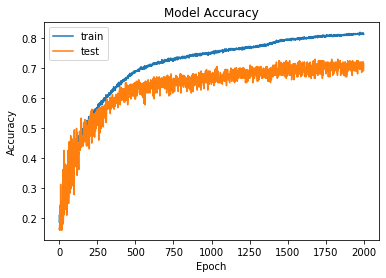

In [56]:
# get train, test and val data
#x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 1, neuron_count = [20], activation_functions = ["sigmoid"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 2000, batch_size = 1, show_output = True)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

Started training.
Finished training.
1018/1018 [==============================] - 0s 21us/step
Model has a loss of 0.6459459902495438 and an accuracy of 0.7760314345359802


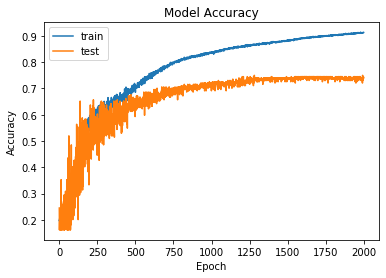

In [54]:
# get train, test and val data
#x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 1, neuron_count = [20], activation_functions = ["sigmoid"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 2000, batch_size = 32, show_output = False)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

Started training.
Finished training.
1018/1018 [==============================] - 0s 20us/step
Model has a loss of 0.8022911257031858 and an accuracy of 0.7003929018974304


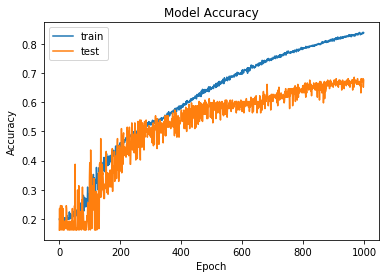

In [21]:
# get train, test and val data
x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 2, neuron_count = [20, 10], activation_functions = ["sigmoid", "relu"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 1000, batch_size = 64, show_output = False)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

Started training.
Finished training.
1018/1018 [==============================] - 0s 19us/step
Model has a loss of 0.8388083584182154 and an accuracy of 0.673870325088501


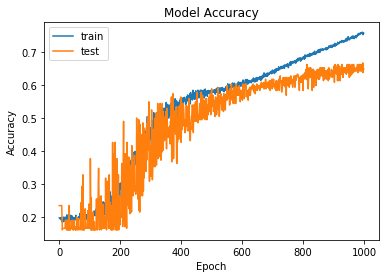

In [22]:
# get train, test and val data
x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 2, neuron_count = [10, 5], activation_functions = ["sigmoid", "sigmoid"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 1000, batch_size = 64, show_output = False)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

Started training.
Finished training.
1018/1018 [==============================] - 0s 17us/step
Model has a loss of 1.0457950588059566 and an accuracy of 0.689587414264679


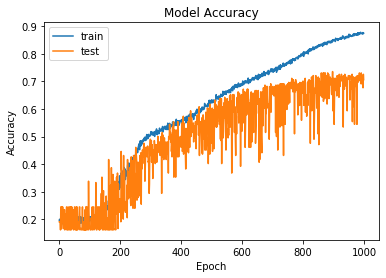

In [23]:
# get train, test and val data
x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 3, neuron_count = [20, 10, 10], activation_functions = ["sigmoid", "sigmoid", "relu"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 1000, batch_size = 64, show_output = False)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

### older tests

Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 5,
                      and an sigmoid main activation function


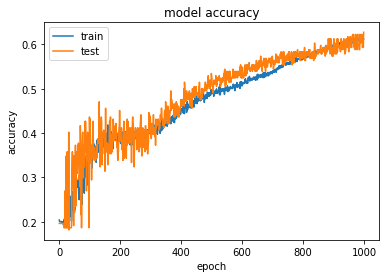

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [1.0605342650460354, 0.5609037280082703]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 5,
                      and an relu main activation function


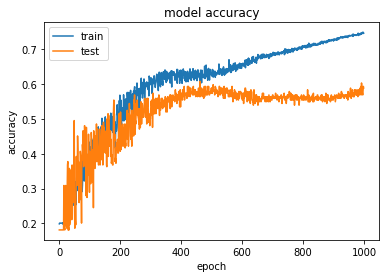

1018/1018 [==============================] - 0s 17us/step
test loss, test acc: [0.9132947702773193, 0.6178781986236572]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 10,
                      and an sigmoid main activation function


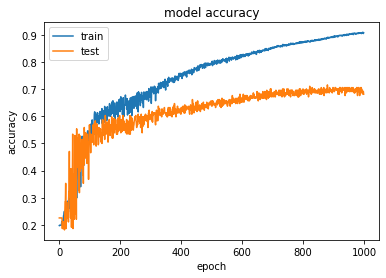

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.6991537325742905, 0.7524557709693909]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 10,
                      and an relu main activation function


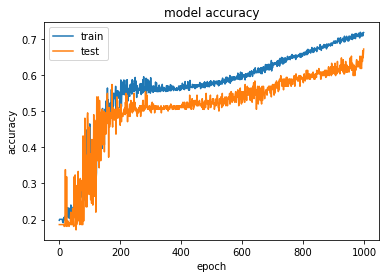

1018/1018 [==============================] - 0s 24us/step
test loss, test acc: [0.9494688950025263, 0.6404715180397034]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 20,
                      and an sigmoid main activation function


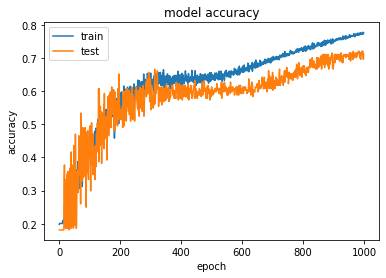

1018/1018 [==============================] - 0s 24us/step
test loss, test acc: [0.863985970001558, 0.6777995824813843]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 20,
                      and an relu main activation function


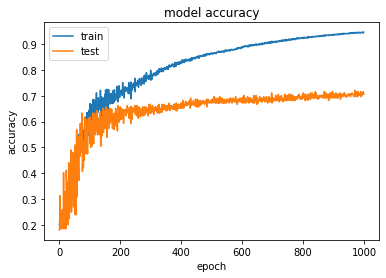

1018/1018 [==============================] - 0s 19us/step
test loss, test acc: [0.6784178030280092, 0.7534381151199341]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 5,
                      and an sigmoid main activation function


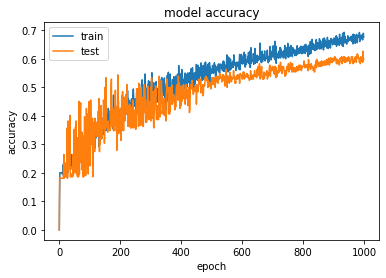

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [1.1259713334512618, 0.6110019683837891]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 5,
                      and an relu main activation function


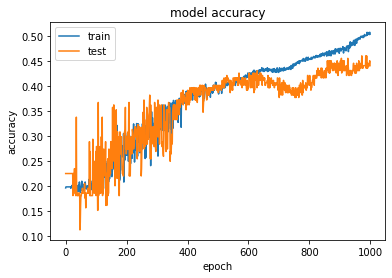

1018/1018 [==============================] - 0s 22us/step
test loss, test acc: [1.1758442962567792, 0.4626719057559967]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 10,
                      and an sigmoid main activation function


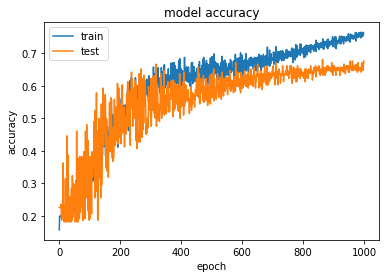

1018/1018 [==============================] - 0s 34us/step
test loss, test acc: [0.9997822439740823, 0.6719056963920593]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 10,
                      and an relu main activation function


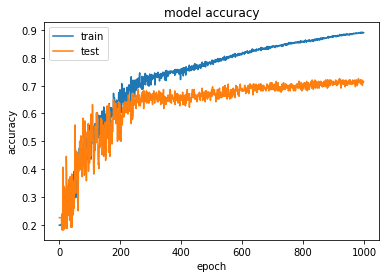

1018/1018 [==============================] - 0s 19us/step
test loss, test acc: [0.7291900711115779, 0.7396856546401978]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 20,
                      and an sigmoid main activation function


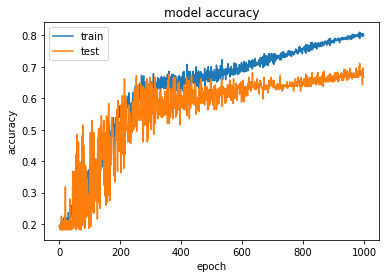

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.8916117187099044, 0.7072691321372986]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 20,
                      and an relu main activation function


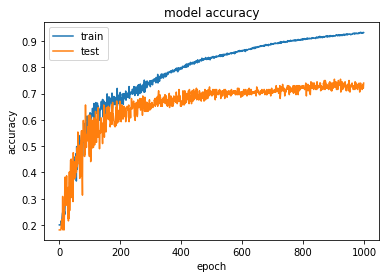

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [0.6940813216807098, 0.7426326274871826]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 5,
                      and an sigmoid main activation function


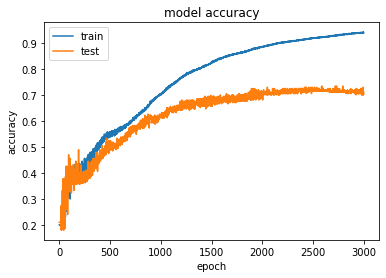

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [0.8966188813707917, 0.7387033104896545]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 5,
                      and an relu main activation function


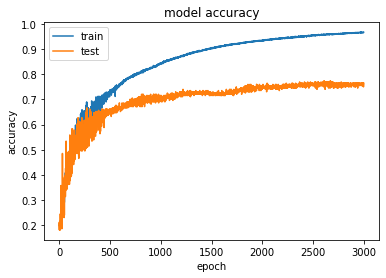

1018/1018 [==============================] - 0s 23us/step
test loss, test acc: [0.8911164929918315, 0.7485265135765076]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 10,
                      and an sigmoid main activation function


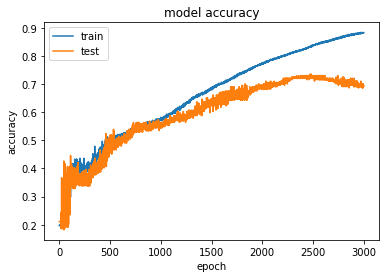

1018/1018 [==============================] - 0s 17us/step
test loss, test acc: [0.7898379283241767, 0.7278978228569031]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 10,
                      and an relu main activation function


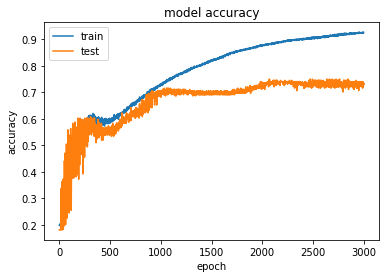

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [0.8475107750864534, 0.7278978228569031]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 20,
                      and an sigmoid main activation function


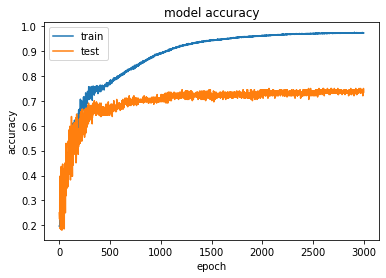

1018/1018 [==============================] - 0s 19us/step
test loss, test acc: [0.9223631476372305, 0.7583497166633606]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 20,
                      and an relu main activation function


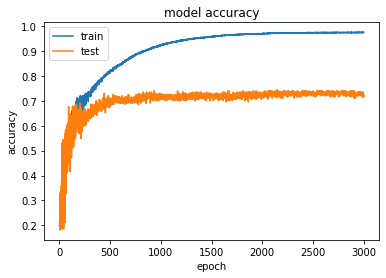

1018/1018 [==============================] - 0s 21us/step
test loss, test acc: [1.0131137100558851, 0.7583497166633606]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 5,
                      and an sigmoid main activation function


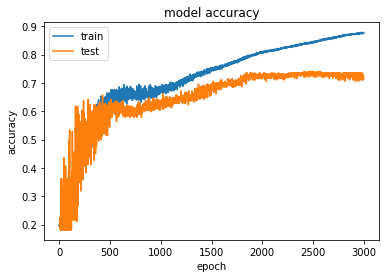

1018/1018 [==============================] - 0s 19us/step
test loss, test acc: [0.7509782258091835, 0.7259331941604614]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 5,
                      and an relu main activation function


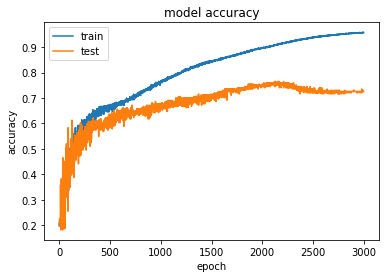

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.8205998383008661, 0.7554027438163757]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 10,
                      and an sigmoid main activation function


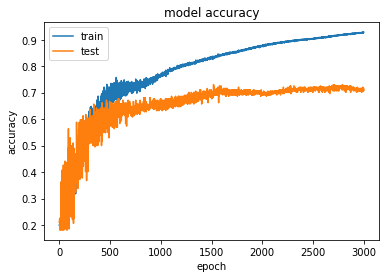

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [0.6963717452669425, 0.7554027438163757]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 10,
                      and an relu main activation function


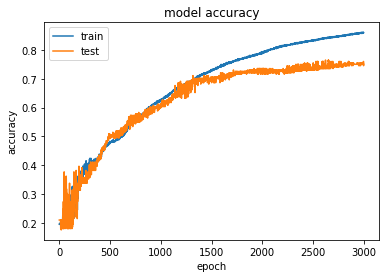

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.9230683423681203, 0.6777995824813843]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 20,
                      and an sigmoid main activation function


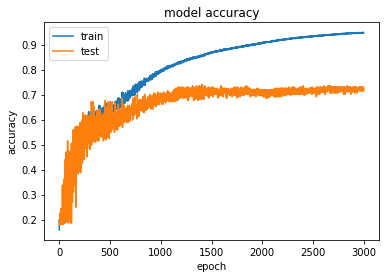

1018/1018 [==============================] - 0s 25us/step
test loss, test acc: [0.6843019648947275, 0.7632613182067871]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 20,
                      and an relu main activation function


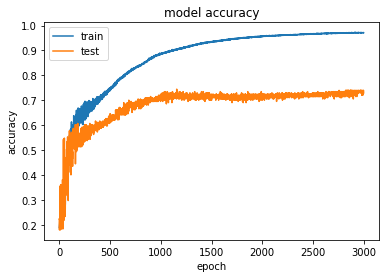

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.89550499702952, 0.7524557709693909]
----------------------------------------------------------------------------------------------------


In [78]:
neuron_count = [5, 10, 20]
second_layer = [True, False]
epochs = [1000, 3000]
main_activation = ["sigmoid", "relu"]

for epoch_count in epochs:

    for second_layer_active in second_layer:
        
        for neuron_number in neuron_count:
            
            for activation in main_activation:

                inputs = keras.Input(shape=(shape,), name="wordvecors")
                x = layers.Dense(neuron_number, activation=activation, name="dense_1")(inputs)

                if second_layer_active:
                    x = layers.Dense(neuron_number, activation="relu", name="dense_1")(x)

                outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

                model = keras.Model(inputs=inputs, outputs=outputs)

                model.compile(
                    optimizer=keras.optimizers.RMSprop(),  # Optimizer
                    # Loss function to minimize
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    # List of metrics to monitor
                    metrics=[keras.metrics.SparseCategoricalAccuracy()],
                )

                print("Fit model on training data")
                history = model.fit(
                    x_train,
                    y_train,
                    batch_size=64,
                    epochs=epoch_count,
                    verbose = 0, # not output
                    validation_data=(x_val, y_val),
                )
                print(f"""Model Data with, epoch count of {epoch_count}, 
                      second layer = {second_layer_active}, neuron number of {neuron_number},
                      and an {activation} main activation function""")
                plt.plot(history.history['sparse_categorical_accuracy'])
                plt.plot(history.history['val_sparse_categorical_accuracy'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                plt.show()
                
                results = model.evaluate(x_test, y_test, batch_size=128)
                print("test loss, test acc:", results)
                
                print(100*"-")

Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 5,
                      and an sigmoid main activation function


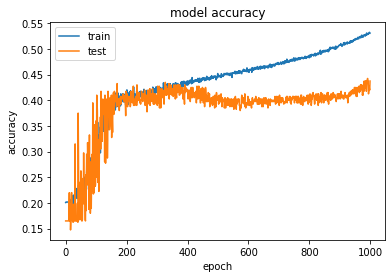

2000/2000 [==============================] - 0s 99us/step
test loss, test acc: [1.2387893695831298, 0.45100000500679016]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 5,
                      and an relu main activation function


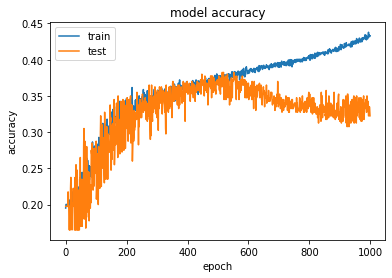

2000/2000 [==============================] - 0s 15us/step
test loss, test acc: [1.509524118423462, 0.33000001311302185]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 10,
                      and an sigmoid main activation function


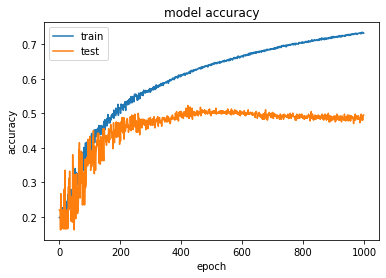

2000/2000 [==============================] - 0s 21us/step
test loss, test acc: [1.2424069805145264, 0.534500002861023]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 10,
                      and an relu main activation function


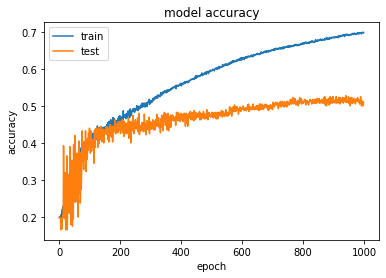

2000/2000 [==============================] - 2s 905us/step
test loss, test acc: [1.210746542930603, 0.5180000066757202]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 20,
                      and an sigmoid main activation function


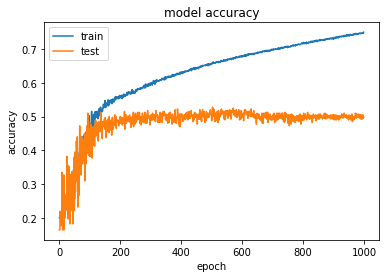

2000/2000 [==============================] - 0s 11us/step
test loss, test acc: [1.2385325870513917, 0.5440000295639038]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 20,
                      and an relu main activation function


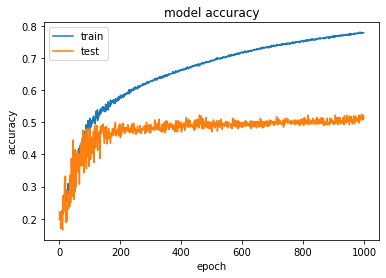

2000/2000 [==============================] - 0s 19us/step
test loss, test acc: [1.290763186454773, 0.5475000143051147]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 5,
                      and an sigmoid main activation function


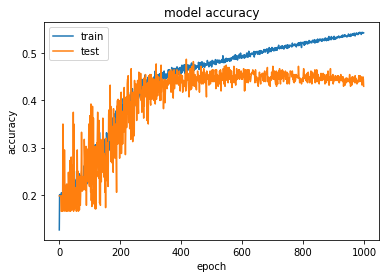

2000/2000 [==============================] - 0s 11us/step
test loss, test acc: [1.2637388706207275, 0.46299999952316284]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 5,
                      and an relu main activation function


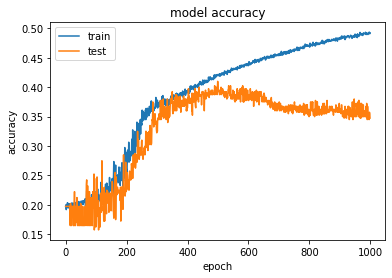

2000/2000 [==============================] - 0s 20us/step
test loss, test acc: [1.2808194189071656, 0.41499999165534973]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 10,
                      and an sigmoid main activation function


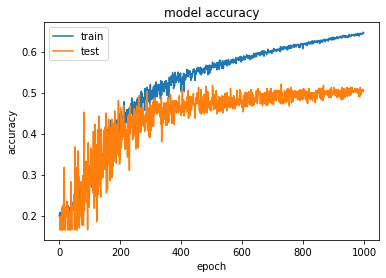

2000/2000 [==============================] - 0s 19us/step
test loss, test acc: [1.2050222911834716, 0.5164999961853027]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 10,
                      and an relu main activation function


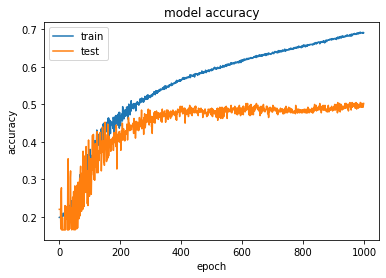

2000/2000 [==============================] - 0s 10us/step
test loss, test acc: [1.2118401889801025, 0.5235000252723694]
----------------------------------------------------------------------------------------------------
Fit model on training data


KeyboardInterrupt: 

In [13]:
# Test with full dataset
neuron_count = [5, 10, 20]
second_layer = [True, False]
epochs = [1000, 3000]
main_activation = ["sigmoid", "relu"]

for epoch_count in epochs:

    for second_layer_active in second_layer:
        
        for neuron_number in neuron_count:
            
            for activation in main_activation:

                inputs = keras.Input(shape=(shape,), name="wordvecors")
                x = layers.Dense(neuron_number, activation=activation, name="dense_1")(inputs)

                if second_layer_active:
                    x = layers.Dense(neuron_number, activation="relu", name="dense_1")(x)

                outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

                model = keras.Model(inputs=inputs, outputs=outputs)

                model.compile(
                    optimizer=keras.optimizers.RMSprop(),  # Optimizer
                    # Loss function to minimize
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    # List of metrics to monitor
                    metrics=[keras.metrics.SparseCategoricalAccuracy()],
                )

                print("Fit model on training data")
                history = model.fit(
                    x_train,
                    y_train,
                    batch_size=64,
                    epochs=epoch_count,
                    verbose = 0, # not output
                    validation_data=(x_val, y_val),
                )
                print(f"""Model Data with, epoch count of {epoch_count}, 
                      second layer = {second_layer_active}, neuron number of {neuron_number},
                      and an {activation} main activation function""")
                plt.plot(history.history['sparse_categorical_accuracy'])
                plt.plot(history.history['val_sparse_categorical_accuracy'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                plt.show()
                
                results = model.evaluate(x_test, y_test, batch_size=128)
                print("test loss, test acc:", results)
                
                print(100*"-")